In [2]:
# import pandas as pd
train_path = "task1_train.csv"
test_path = "task1_test.csv"
sample_path = "task1_sample_submission.csv"

train = pd.read_csv(f"../input/intro-ml-2025-nccu-task1/{train_path}")
test = pd.read_csv(f"../input/intro-ml-2025-nccu-task1/{test_path}")
sample_submission = pd.read_csv(f"../input/intro-ml-2025-nccu-task1/{sample_path}")

Train shape: (800, 11)
Test shape: (200, 11)
Sample submission shape: (200, 2)
        x_1       x_2       x_3       x_4       x_5       x_6       x_7  \
0  1.820093  0.159476  0.582088  0.373024  0.442973  0.997336  0.425163   
1 -2.935780 -0.334644  1.923015 -0.980030 -0.364582  0.631167  0.944346   
2 -0.544894 -0.895405  0.051421  0.212954 -0.390282  0.164977  0.926398   
3 -1.119096  0.715454  1.362240  1.133906 -1.120646  0.529612  0.083462   
4  1.171124  0.053573  0.703804  0.959912 -0.967465  0.239100  0.487664   

        x_8       x_9      x_10     value  
0  0.862518  0.013018  0.732294 -0.212492  
1  0.545469  0.087426  0.407761  1.241630  
2  0.562036  0.163946  0.639655 -1.494749  
3  0.459198  0.448113  0.802317  3.895388  
4  0.690517  0.877920  0.513218  4.257469  

Missing values in train:
x_1      0
x_2      0
x_3      0
x_4      0
x_5      0
x_6      0
x_7      0
x_8      0
x_9      0
x_10     0
value    0
dtype: int64

Missing values in test:
id      0
x_1     0
x

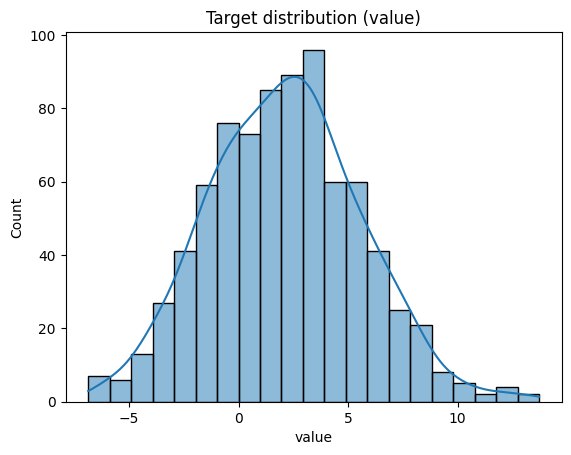


Correlation with target:
value    1.000000
x_4      0.735578
x_2      0.221290
x_9      0.166096
x_1      0.079122
x_6      0.061920
x_8      0.061547
x_5      0.047744
x_7      0.005270
x_10    -0.003956
x_3     -0.066676
Name: value, dtype: float64

[Baseline] Mean model MSE on train: 11.83850
[Baseline] Ridge CV MSE: 4.30819 ± 0.25406

[Ridge] Best CV MSE: 4.307871262519066
[Ridge] Best params: {'model__alpha': 4.714866363457395}

[Lasso] Best CV MSE: 4.296411719693465
[Lasso] Best params: {'model__alpha': 0.03556480306223128}

[ElasticNet] Best CV MSE: 4.30098415519187
[ElasticNet] Best params: {'model__l1_ratio': 0.9, 'model__alpha': 0.011721022975334805}

[RandomForest] Best CV MSE: 4.910100488454391
[RandomForest] Best params: {'model__n_estimators': 600, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_depth': 7}

[KNN] Best CV MSE: 6.494183606444298
[KNN] Best params: {'model__weights': 'distance', 'model__p': 2, 'model__n_neighbors': 13}

[SVR] Best 

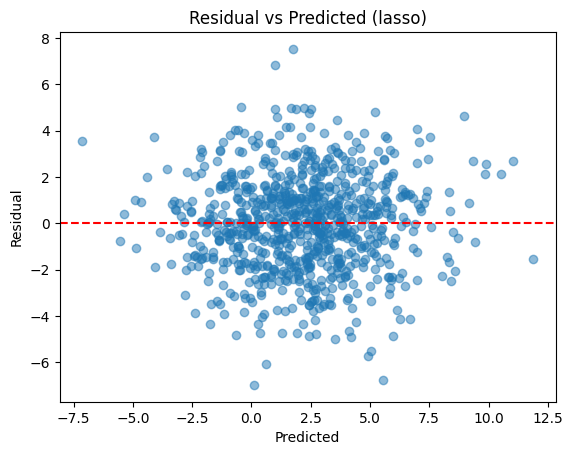


Submission preview:
   id     value
0   1  2.161099
1   2  1.971839
2   3  0.810882
3   4 -0.790346
4   5 -0.245731

Saved submission.csv


In [3]:
# =========================================================
# Step 0: 基本設定 & 套件
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.base import clone

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# =========================================================
# Step 1: 讀取資料 & 理解結構
# =========================================================
# 如果在 Kaggle，可以直接用相對路徑，確保三個檔案在同一個資料夾
# train = pd.read_csv("task1_train.csv")
# test = pd.read_csv("task1_test.csv")
# sample_submission = pd.read_csv("task1_sample_submission.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Sample submission shape:", sample_submission.shape)
print(train.head())

# 依照題目假設欄位名稱為 x_1 ~ x_10, value, test 有 id + x_1 ~ x_10
target_col = "value"
id_col = "id"
feature_cols = [c for c in train.columns if c not in [target_col]]

X = train[feature_cols]
y = train[target_col]
X_test = test[feature_cols]

numeric_features = feature_cols  # 這題全部都是數值特徵

# =========================================================
# Step 2: EDA & 前處理 (簡化版，實戰可以再加圖)
# =========================================================

# 2-1 缺失值檢查
print("\nMissing values in train:")
print(train.isna().sum())
print("\nMissing values in test:")
print(test.isna().sum())

# 若有缺失，最簡單做法：用中位數補值 (這裡示範)
for col in numeric_features:
    med = train[col].median()
    train[col] = train[col].fillna(med)
    test[col] = test[col].fillna(med)

X = train[feature_cols]
X_test = test[feature_cols]

# 2-2 目標分佈
plt.figure()
sns.histplot(y, kde=True)
plt.title("Target distribution (value)")
plt.show()

# 2-3 特徵與目標相關性
corr = train[numeric_features + [target_col]].corr()[target_col].sort_values(ascending=False)
print("\nCorrelation with target:")
print(corr)

# =========================================================
# Step 3: 特徵工程 (標準化 + 可選的多項式特徵)
# =========================================================

# 針對需要標準化的模型 (線性、KNN、SVR 等)，建立通用前處理
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

preprocess_for_linear = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
    ],
    remainder="drop"
)

# 若要加一點非線性：多項式特徵 (degree=2，避免過度爆炸)
poly_transformer = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False))
])

preprocess_for_poly = ColumnTransformer(
    transformers=[
        ("num", poly_transformer, numeric_features)
    ],
    remainder="drop"
)

# 對樹模型通常不需要標準化
preprocess_for_tree = "passthrough"

# =========================================================
# Step 4: 建立基準模型 (Baseline)
# =========================================================

# 4-1 Mean model (只當 baseline 比較，不會真的用來預測)
y_mean = y.mean()
mean_mse = mean_squared_error(y, np.full_like(y, y_mean))
print(f"\n[Baseline] Mean model MSE on train: {mean_mse:.5f}")

# 4-2 簡單 Ridge baseline
ridge_baseline = Pipeline(steps=[
    ("preprocess", preprocess_for_linear),
    ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE))
])

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
ridge_cv_scores = -cross_val_score(
    ridge_baseline, X, y,
    scoring="neg_mean_squared_error",
    cv=kf
)
print(f"[Baseline] Ridge CV MSE: {ridge_cv_scores.mean():.5f} ± {ridge_cv_scores.std():.5f}")

# =========================================================
# Step 5 & 7: 嘗試多種模型 + 超參數調校
# =========================================================
models = {}

# 5-1 Ridge (with CV tuning)
ridge_pipe = Pipeline(steps=[
    ("preprocess", preprocess_for_linear),
    ("model", Ridge(random_state=RANDOM_STATE))
])

ridge_param_dist = {
    "model__alpha": np.logspace(-3, 3, 50)
}

ridge_search = RandomizedSearchCV(
    ridge_pipe,
    param_distributions=ridge_param_dist,
    n_iter=30,
    scoring="neg_mean_squared_error",
    cv=kf,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
ridge_search.fit(X, y)
print("\n[Ridge] Best CV MSE:", -ridge_search.best_score_)
print("[Ridge] Best params:", ridge_search.best_params_)
models["ridge"] = ridge_search.best_estimator_

# 5-2 Lasso
lasso_pipe = Pipeline(steps=[
    ("preprocess", preprocess_for_linear),
    ("model", Lasso(random_state=RANDOM_STATE, max_iter=10000))
])

lasso_param_dist = {
    "model__alpha": np.logspace(-4, 1, 50)
}

lasso_search = RandomizedSearchCV(
    lasso_pipe,
    param_distributions=lasso_param_dist,
    n_iter=30,
    scoring="neg_mean_squared_error",
    cv=kf,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
lasso_search.fit(X, y)
print("\n[Lasso] Best CV MSE:", -lasso_search.best_score_)
print("[Lasso] Best params:", lasso_search.best_params_)
models["lasso"] = lasso_search.best_estimator_

# 5-3 ElasticNet
enet_pipe = Pipeline(steps=[
    ("preprocess", preprocess_for_linear),
    ("model", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

enet_param_dist = {
    "model__alpha": np.logspace(-4, 1, 30),
    "model__l1_ratio": np.linspace(0.1, 0.9, 9)
}

enet_search = RandomizedSearchCV(
    enet_pipe,
    param_distributions=enet_param_dist,
    n_iter=40,
    scoring="neg_mean_squared_error",
    cv=kf,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
enet_search.fit(X, y)
print("\n[ElasticNet] Best CV MSE:", -enet_search.best_score_)
print("[ElasticNet] Best params:", enet_search.best_params_)
models["elasticnet"] = enet_search.best_estimator_

# 5-4 Random Forest
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess_for_tree),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE))
])

rf_param_dist = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [3, 5, 7, 9, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=40,
    scoring="neg_mean_squared_error",
    cv=kf,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
rf_search.fit(X, y)
print("\n[RandomForest] Best CV MSE:", -rf_search.best_score_)
print("[RandomForest] Best params:", rf_search.best_params_)
models["rf"] = rf_search.best_estimator_

# 5-5 KNN
knn_pipe = Pipeline(steps=[
    ("preprocess", preprocess_for_linear),
    ("model", KNeighborsRegressor())
])

knn_param_dist = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 13],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]  # Manhattan / Euclidean
}

knn_search = RandomizedSearchCV(
    knn_pipe,
    param_distributions=knn_param_dist,
    n_iter=30,
    scoring="neg_mean_squared_error",
    cv=kf,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
knn_search.fit(X, y)
print("\n[KNN] Best CV MSE:", -knn_search.best_score_)
print("[KNN] Best params:", knn_search.best_params_)
models["knn"] = knn_search.best_estimator_

# 5-6 SVR
svr_pipe = Pipeline(steps=[
    ("preprocess", preprocess_for_linear),
    ("model", SVR())
])

svr_param_dist = {
    "model__C": np.logspace(-1, 3, 20),
    "model__gamma": ["scale", "auto"] + list(np.logspace(-3, 0, 10)),
    "model__epsilon": np.logspace(-3, 0, 10)
}

svr_search = RandomizedSearchCV(
    svr_pipe,
    param_distributions=svr_param_dist,
    n_iter=40,
    scoring="neg_mean_squared_error",
    cv=kf,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
svr_search.fit(X, y)
print("\n[SVR] Best CV MSE:", -svr_search.best_score_)
print("[SVR] Best params:", svr_search.best_params_)
models["svr"] = svr_search.best_estimator_

# 5-7 (Optional) XGBoost / LightGBM，如果沒裝就略過
try:
    from xgboost import XGBRegressor

    xgb_pipe = Pipeline(steps=[
        ("preprocess", preprocess_for_tree),
        ("model", XGBRegressor(
            objective="reg:squarederror",
            random_state=RANDOM_STATE,
            tree_method="hist"  # Kaggle GPU 可改為 "gpu_hist"
        ))
    ])

    xgb_param_dist = {
        "model__n_estimators": [200, 400, 600],
        "model__max_depth": [3, 4, 5, 6],
        "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "model__subsample": [0.7, 0.8, 1.0],
        "model__colsample_bytree": [0.7, 0.8, 1.0]
    }

    xgb_search = RandomizedSearchCV(
        xgb_pipe,
        param_distributions=xgb_param_dist,
        n_iter=40,
        scoring="neg_mean_squared_error",
        cv=kf,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0
    )
    xgb_search.fit(X, y)
    print("\n[XGBoost] Best CV MSE:", -xgb_search.best_score_)
    print("[XGBoost] Best params:", xgb_search.best_params_)
    models["xgb"] = xgb_search.best_estimator_

except Exception as e:
    print("\n[XGBoost] Not available or failed to import:", e)

# =========================================================
# Step 6: 評估各模型 (K-fold CV: MSE, RMSE, MAE)
# =========================================================
model_scores = {}

for name, model in models.items():
    mse_scores = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf, n_jobs=-1)
    rmse_scores = np.sqrt(mse_scores)
    mae_scores = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)

    model_scores[name] = {
        "mse_mean": mse_scores.mean(),
        "mse_std": mse_scores.std(),
        "rmse_mean": rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "mae_mean": mae_scores.mean(),
        "mae_std": mae_scores.std()
    }

print("\nModel CV performance:")
for name, s in model_scores.items():
    print(f"{name:10s} | MSE: {s['mse_mean']:.5f} ± {s['mse_std']:.5f} | "
          f"RMSE: {s['rmse_mean']:.5f} | MAE: {s['mae_mean']:.5f}")

# =========================================================
# Step 8: 集成方法 (加權平均 + Bagging + Clipping)
# =========================================================

# 8-1 根據 CV MSE 來算權重 (MSE 越小權重越大)
valid_models = [m for m in model_scores.keys()]
mse_list = np.array([model_scores[m]["mse_mean"] for m in valid_models])

# 避免被 0 除，取 1 / (mse + 1e-6)
raw_weights = 1.0 / (mse_list + 1e-6)
weights = raw_weights / raw_weights.sum()

print("\nEnsemble weights (by CV MSE):")
for m, w in zip(valid_models, weights):
    print(f"{m:10s}: {w:.4f}")

# 8-2 Bagging + 預測 + Ensemble
# 使用多個 random_state 進行 bagging (對有 random_state 的模型最有用)
bagging_seeds = [0, 42, 123, 2024, 999]

# 收集每個模型的最終預測 (test 上)
model_test_preds = {}

y_min, y_max = y.min(), y.max()  # 用於 clipping

for name in valid_models:
    base_model = models[name]
    bagged_preds = []

    for seed in bagging_seeds:
        model_clone = clone(base_model)
        # 嘗試設定 random_state (如果有這個參數)
        try:
            # 這樣可以避免你之前遇到 Pipeline __init__ unexpected keyword 的問題
            if hasattr(model_clone, "set_params"):
                model_clone.set_params(
                    **{k: seed for k in model_clone.get_params().keys() if k.endswith("random_state")}
                )
        except Exception:
            pass

        model_clone.fit(X, y)
        pred = model_clone.predict(X_test)
        bagged_preds.append(pred)

    bagged_preds = np.mean(bagged_preds, axis=0)
    # Clipping：避免極端值
    bagged_preds = np.clip(bagged_preds, y_min, y_max)

    model_test_preds[name] = bagged_preds

# 8-3 Ensemble: 依照權重加權平均
final_pred = np.zeros_like(list(model_test_preds.values())[0])

for (name, w) in zip(valid_models, weights):
    final_pred += w * model_test_preds[name]

# 最後再做一次 clipping (保險)
final_pred = np.clip(final_pred, y_min, y_max)

# =========================================================
# Step 9: (簡單版) 殘差分析 — 這裡用最好的單一模型做 OOF 殘差
# =========================================================
# 找單一模型中 CV MSE 最好的那一個
best_single_name = min(valid_models, key=lambda m: model_scores[m]["mse_mean"])
best_single_model = models[best_single_name]

print(f"\nBest single model by CV MSE: {best_single_name}")

# 手動做一次 OOF 預測
oof_pred = np.zeros(len(X))
for train_idx, valid_idx in kf.split(X, y):
    X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]
    m = clone(best_single_model)
    m.fit(X_tr, y_tr)
    oof_pred[valid_idx] = m.predict(X_val)

residuals = y - oof_pred

plt.figure()
plt.scatter(oof_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title(f"Residual vs Predicted ({best_single_name})")
plt.show()

# =========================================================
# Step 10: 產生最終上傳檔 submission.csv
# =========================================================
submission = sample_submission.copy()
submission["value"] = final_pred  # 確保欄位名稱跟 sample_submission 一樣

print("\nSubmission preview:")
print(submission.head())

submission.to_csv("submission_task1_v3.csv", index=False)
print("\nSaved submission.csv")
